# Load corpus PMIDs

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("metadata.csv", index_col=None, header=0, encoding="latin-1")
df = df.dropna(subset=["PMID"])
df["PMID"] = df["PMID"].astype(int)
len(df)

18155

In [3]:
pmids = sorted(list(df["PMID"]))
pmids[:3]

[1402966, 1410086, 1448149]

# Map coordinates to brain atlas structures

In [4]:
import os
import preproc_coords

In [5]:
mapped_pmids = [int(file.replace(".txt", "")) for file in os.listdir("../../cogneuro/coordinates/0mm") if not file.startswith(".")]
len(mapped_pmids)

18169

In [6]:
pmids_to_map = set(pmids).difference(set(mapped_pmids))
pmids_to_map

set()

In [7]:
path = "../../cogneuro"
for pmid in pmids_to_map:
    coords = df.loc[df["PMID"] == pmid, "MNI_COORDINATES"].values[0].split(";")
    preproc_coords.run_preproc(path, coords, pmid, smoothing_sigma=0, mask_path=path)

# Compute document-structure matrix

In [8]:
def gen_label_bilateral(label):
    
    parts_to_replace = {"_cerebellar_vermis": ["_vermis_crus_i", "_vermis_crus_ii", "_vermis_vi", "_vermis_viib", "_vermis_viiia", "_vermis_viiib", "vermis_ix", "vermis_x"],
                        "_cerebellar_crus": ["_crus_i", "_crus_ii"],
                        "_cerebellar_lobules": ["_iiv", "_v", "_vi", "_viib", "_viiia", "_viiib", "_ix", "_x"]}
    for replacement, parts in parts_to_replace.items():
        for part in parts:
            if label.endswith(part):
                label = label.replace(part, replacement)
                
    parts_to_remove = ["juxtapositional_lobule_cortex_(formerly_", ")", "_(includes_h1_and_h2"]
    for part in parts_to_remove:
        label = label.replace(part, "")
    
    return label.strip()

In [9]:
def prob_thres_dcm(pmids, prob, sigma=0, labs=[], verbose=True,
                   input_path="../", outfile="coordinates_combo.csv"): 

    dcm = {}
    for i, pmid in enumerate(pmids):
        
        if verbose and i % 2000 == 0:
            print("Processing the {}th PMID".format(i))
        
        dcm[pmid] = {}
        dcm[pmid]["PMID"] = int(pmid)
        infile = "{}coordinates/{}mm/{}.txt".format(input_path, sigma, int(pmid))
        lines = open(infile, "r").readlines()
        hits = []
        
        for line in lines:
            for struct in line.split(","):
                if len(struct.split()) == 2:
                    label, p = struct.split()
                    if float(p) > prob:
                        hits += [gen_label_bilateral(label)]
        
        for label in labs:
            count = hits.count(label)
            if count > 0:
                dcm[pmid][label] = 1
            else:
                dcm[pmid][label] = 0
    
    with open(outfile, "w+"):
        out = pd.DataFrame(dcm).transpose()
        out.to_csv(outfile, index=False, quoting=1, columns=["PMID"] + labs)

In [10]:
lab_df = pd.read_csv("brain/labels_combo.csv")
labs = list(lab_df["PREPROCESSED"])
lab_df.head()

,INDEX,TITLE,PREPROCESSED,PRESENTABLE_LOWER,PRESENTABLE,PRESENTABLE_TITLE,ABBREVIATION
0,1,Left Frontal Pole,left_frontal_pole,left frontal pole,Left Frontal Pole,Frontal pole (L),FP (L)
1,2,Left Insular Cortex,left_insular_cortex,left insular cortex,Left Insular Cortex,Insular cortex (L),Insula (L)
2,3,Left Superior Frontal Gyrus,left_superior_frontal_gyrus,left superior frontal gyrus,Left Superior Frontal Gyrus,Superior frontal gyrus (L),SFG (L)
3,4,Left Middle Frontal Gyrus,left_middle_frontal_gyrus,left middle frontal gyrus,Left Middle Frontal Gyrus,Middle frontal gyrus (L),MFG (L)
4,5,Left Inferior Frontal Gyrus pars triangularis,left_inferior_frontal_gyrus_pars_triangularis,"left IFG, pars triangularis","Left IFG, Pars Triangularis","IFG, pars triangularis (L)",trIFG (L)


In [11]:
prob_thres_dcm(pmids, 0, sigma=0, labs=labs, 
               input_path="../../cogneuro/", outfile="brain/coordinates_combo.csv")

Processing the 0th PMID
Processing the 2000th PMID
Processing the 4000th PMID
Processing the 6000th PMID
Processing the 8000th PMID
Processing the 10000th PMID
Processing the 12000th PMID
Processing the 14000th PMID
Processing the 16000th PMID
Processing the 18000th PMID


# Check number of coordinates per structure

In [12]:
act = pd.read_csv("brain/coordinates_combo.csv", index_col=0)
act.head()

,left_frontal_pole,left_insular_cortex,left_superior_frontal_gyrus,left_middle_frontal_gyrus,left_inferior_frontal_gyrus_pars_triangularis,left_inferior_frontal_gyrus_pars_opercularis,left_precentral_gyrus,left_temporal_pole,left_superior_temporal_gyrus_anterior_division,left_superior_temporal_gyrus_posterior_division,...,right_caudate,right_putamen,right_pallidum,right_hippocampus,right_amygdala,right_accumbens,right_brainstem,right_cerebellar_lobules,right_cerebellar_crus,right_cerebellar_vermis
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1410086,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1448149,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
1486459,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
for lab in labs:
    print("{:55s}{:5d}".format(lab, sum(act[lab])))

left_frontal_pole                                       9534
left_insular_cortex                                     6800
left_superior_frontal_gyrus                             8906
left_middle_frontal_gyrus                               9852
left_inferior_frontal_gyrus_pars_triangularis           7138
left_inferior_frontal_gyrus_pars_opercularis            8096
left_precentral_gyrus                                  10682
left_temporal_pole                                      4332
left_superior_temporal_gyrus_anterior_division          3255
left_superior_temporal_gyrus_posterior_division         6583
left_middle_temporal_gyrus_anterior_division            2754
left_middle_temporal_gyrus_posterior_division           5328
left_middle_temporal_gyrus_temporooccipital_part        5917
left_inferior_temporal_gyrus_anterior_division          1502
left_inferior_temporal_gyrus_posterior_division         3613
left_inferior_temporal_gyrus_temporooccipital_part      4909
left_postcentral_gyrus  

# Plot proportion of documents reporting structures

## Bar chart

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
font = "../style/Arial Unicode.ttf"
font_sm = mpl.font_manager.FontProperties(fname=font, size=10)
font_md = mpl.font_manager.FontProperties(fname=font, size=12)
font_lg = mpl.font_manager.FontProperties(fname=font, size=14)
mpl.rcParams["axes.linewidth"] = 1.5

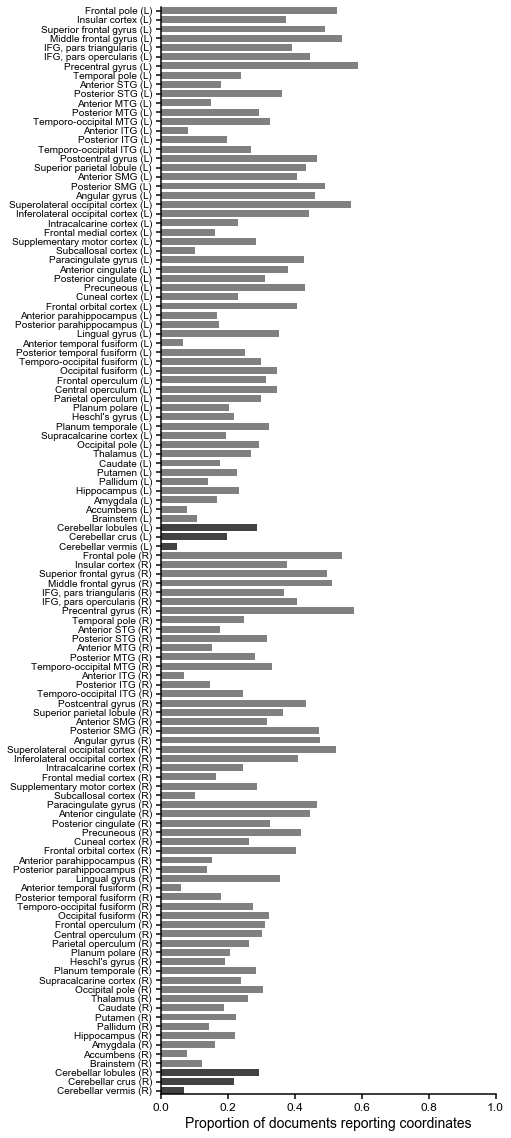

In [16]:
fig, ax = plt.subplots(figsize=(6,20))

x = list(reversed(range(len(act.columns))))
y = act.sum().values / len(act)
ax.barh(x, y, tick_label=lab_df["PRESENTABLE_TITLE"], height=0.75, linewidth=1,
        align="center", color=["gray"]*56 + ["#424242"]*3 + ["gray"]*56 + ["#424242"]*3)

ax.xaxis.set_tick_params(width=1.5, length=5)
ax.yaxis.set_tick_params(width=1.5, length=5)

plt.xlim([0,1])

plt.xticks(fontproperties=font_md)
plt.yticks(fontproperties=font_sm)

plt.xlabel("Proportion of documents reporting coordinates", fontproperties=font_lg)

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)
      
plt.margins(y=0)

plt.savefig("figures/combo/proportion_bar.png", dpi=250, bbox_inches="tight")
plt.show()

## Brain atlas

In [17]:
import sys
sys.path.append("..")
import utilities

In [18]:
atlas = utilities.load_atlas(cerebellum="combo")

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
data = pd.DataFrame({"proportion": act.sum() / len(act)})
data.head(int(len(act)/2))

,proportion
left_frontal_pole,0.525145
left_insular_cortex,0.374552
left_superior_frontal_gyrus,0.490554
left_middle_frontal_gyrus,0.542660
left_inferior_frontal_gyrus_pars_triangularis,0.393170
left_inferior_frontal_gyrus_pars_opercularis,0.445938
left_precentral_gyrus,0.588378
left_temporal_pole,0.238612
left_superior_temporal_gyrus_anterior_division,0.179289
left_superior_temporal_gyrus_posterior_division,0.362600



proportion


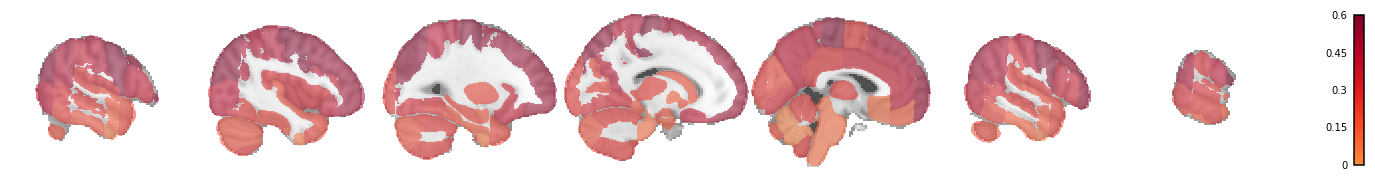


proportion


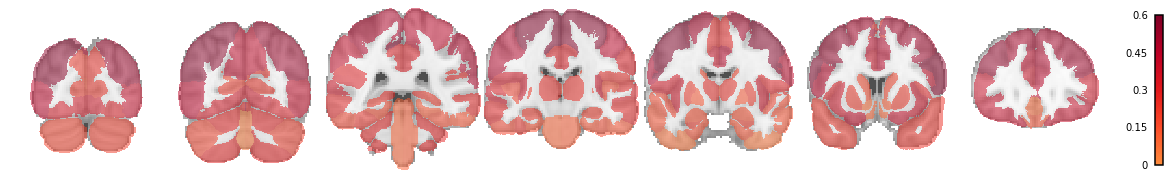


proportion


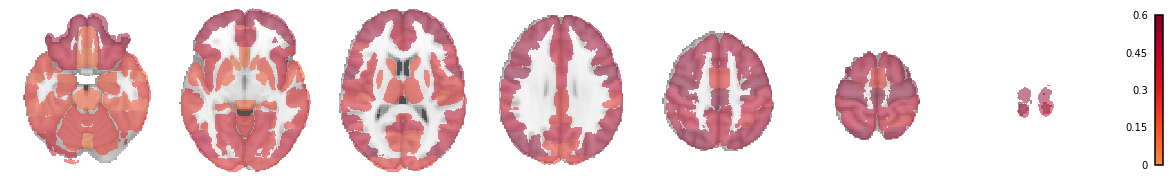


proportion


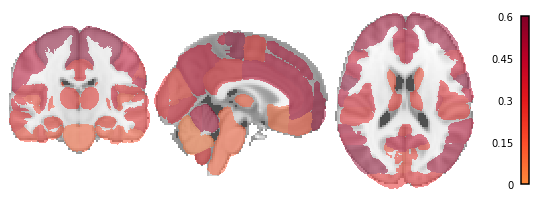

In [20]:
for plane in ["x", "y", "z", "ortho"]:
    utilities.map_plane(data, atlas, "figures/combo", suffix="_" + plane, plane=plane, 
                        cmaps=["YlOrRd"], cbar=True, vmin=0.0, vmax=0.6,
                        verbose=False, print_fig=True, annotate=False)